In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
import filter_utils as filt

In [3]:
data_dir = "./data/"
data_fn = data_dir + "cleaned_data.txt"
data_grey_fn = data_dir + "cleaned_grey_values.txt"

In [4]:
all_elements = pd.read_csv(data_fn)
print(all_elements.head())

   Distance (um)  Elapsed Time   B11_ppm  Na23_ppm  Mg25_ppm  Al27_ppm  \
0      -1.483983     -1.483983 -0.000987 -1.739987  1.252779 -1.428722   
1      -1.478071     -1.478071  0.273978 -0.963147  2.358353 -1.189735   
2      -1.472164     -1.472164 -0.041514 -1.274842  1.587131 -0.879393   
3      -1.466252     -1.466252  0.646814 -0.961113  1.437627 -1.582681   
4      -1.460344     -1.460344  0.151465 -1.214546  1.474992 -1.570397   

   Si28_ppm   P31_ppm   S34_ppm  Cl35_ppm  ...  Zn66_ppm  Zn68_ppm  Sr88_ppm  \
0 -1.030042  1.095407  0.576121 -1.078462  ...  1.409131  1.572304  1.231484   
1 -0.483173  1.588047  1.585102 -1.104329  ...  1.439062  1.372410  0.979279   
2 -0.694485  1.389658  0.317097 -0.880657  ...  1.674240  1.736563  0.941318   
3 -1.052700  1.525399 -0.236500 -1.136729  ...  1.628649  1.488895 -0.189878   
4 -1.296695  1.237596 -0.067184 -1.486543  ...  1.335298  1.297910  0.958900   

   Ba138_ppm  PbTotal_ppm     pixel  new_distance  new_pixel  case  sex  


In [5]:
grey_values = pd.read_csv(data_grey_fn)
print(grey_values)

      Distance_(pixels)  Gray_Value  new_pixel  case  cleaned_grey sex
0                   432    126.7965          0    43      4.842583   M
1                   433    126.2878          1    43      4.838563   M
2                   434    123.3846          2    43      4.815306   M
3                   435    120.0393          3    43      4.787819   M
4                   436    118.5882          4    43      4.775657   M
...                 ...         ...        ...   ...           ...  ..
5678               1746    104.8251       1480    56      4.631919   F
5679               1747    104.6929       1481    56      4.631425   F
5680               1748    103.3024       1482    56      4.637661   F
5681               1749    101.6086       1483    56      4.621128   F
5682               1750    101.0000       1484    56      4.615121   F

[5683 rows x 6 columns]


In [6]:
elt_name = "S34_ppm" # "Sr88_ppm" # "Mg25_ppm" # "Cu65_ppm" # "Zn66_ppm" # 
elt_array = [
    all_elements[all_elements['case']==i][elt_name] for i in [43,44,55,56]
]

In [7]:
bandwidth = 30

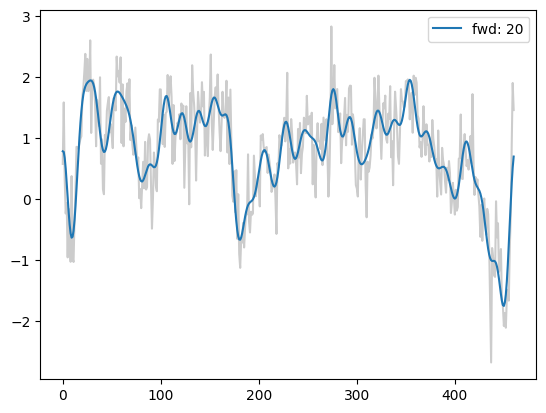

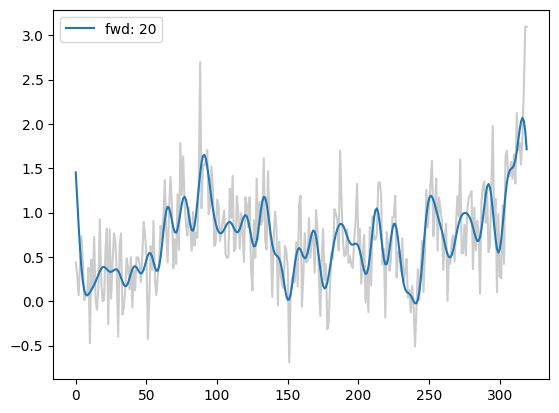

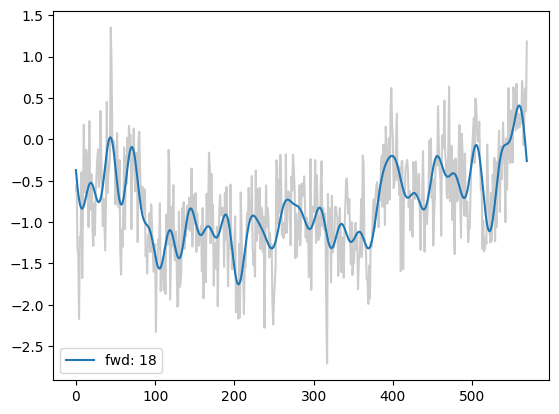

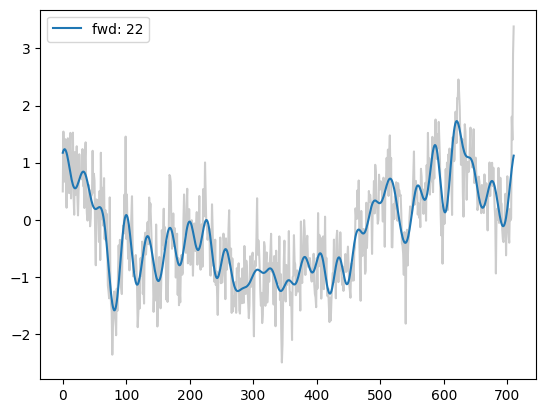

In [11]:
plts = []
fwd_yr_lens_array = []
bkwd_yr_lens_array = []
for i in range(len(elt_array)):
    elt = np.asarray(elt_array[i])
    fwd_count, fwd_locations, fwd_smoothed = filt.age_shark(
        elt, bandwidth, "forward",
    )\
    # bkwd_count, bkwd_locations, bkwd_smoothed = filt.age_shark(
    #     elt, bandwidth, "backward",
    # )

    p = plt.figure()
    p = plt.plot(range(len(elt)), elt, color="grey", alpha=0.4)
    p = plt.plot(fwd_smoothed, label=f"fwd: {fwd_count}")
    # p = plt.plot(bkwd_smoothed, label=f"bkwd: {bkwd_count}")
    p = plt.legend()
    
    plts.append(p)

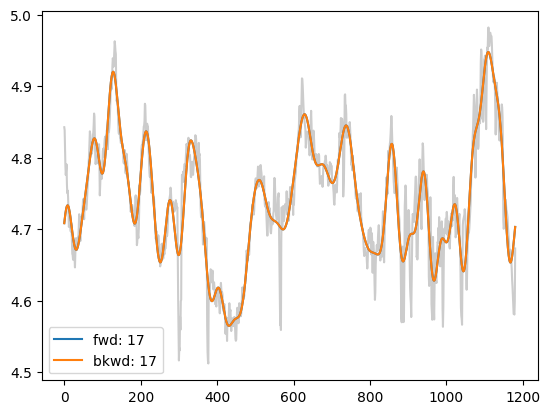

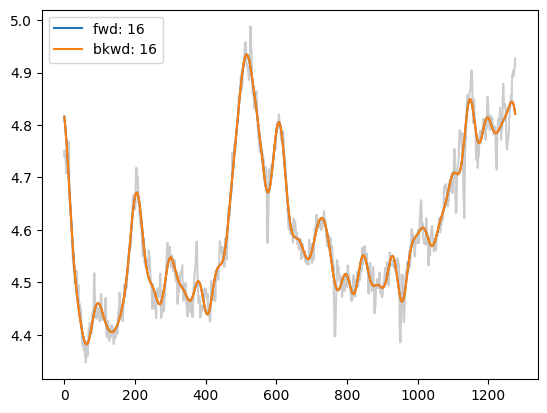

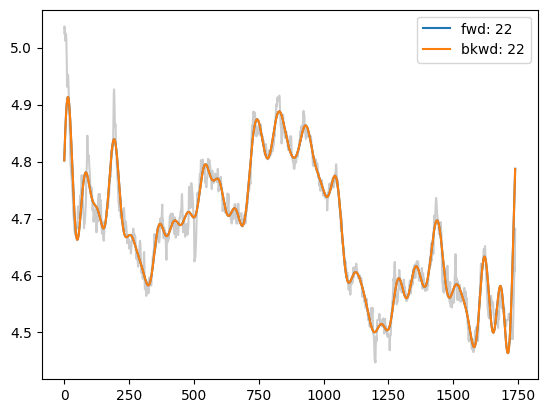

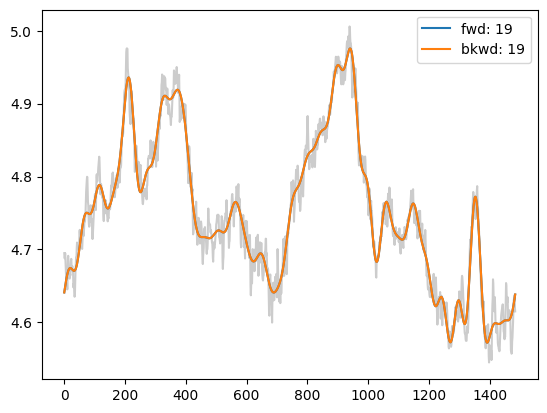

In [9]:
grey_array = [
    grey_values[grey_values['case']==i]['cleaned_grey'] for i in [43,44,55,56]
]
plts = []
for i in range(len(grey_array)):
    grey_val = np.asarray(grey_array[i])
    fwd_count, fwd_locations, fwd_smoothed = filt.age_shark(
        grey_val, bandwidth, "forward",
    )
    bkwd_count, bkwd_locations, bkwd_smoothed = filt.age_shark(
        grey_val, bandwidth, "backward",
    )

    p = plt.figure()
    p = plt.plot(range(len(grey_val)), grey_val, color="grey", alpha=0.4)
    p = plt.plot(fwd_smoothed, label=f"fwd: {fwd_count}")
    p = plt.plot(bkwd_smoothed, label=f"bkwd: {bkwd_count}")
    p = plt.legend()
    
    plts.append(p)

In [10]:
(elt_array[0])

0      0.576121
1      1.585102
2      0.317097
3     -0.236500
4     -0.067184
         ...   
456   -0.822122
457   -0.262803
458    0.886909
459    1.904121
460    1.460023
Name: S34_ppm, Length: 461, dtype: float64